In [1]:
import os 
# set environment variable PYTORCH_ENABLE_MPS_FALLBACK=1
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [21]:
from functools import partial
from tqdm import tqdm
import torch 
import numpy as np

import transformer_lens

from hex_nn.datasets import get_token_dataset
from hex_nn.masking.behaviors import registry as behavior_registry
from hex_nn.masking.triggers import registry as trigger_registry
from hex_nn.masking.distinctions import get_behavior_examples
from hex_nn.datasets import cache_json

from cupbearer import tasks, scripts, detectors
from cupbearer.tasks.tiny_natural_mechanisms import TinyNaturalMechanismsDataset


# Hex Dataset with Pythia-70m tokenizer

The hex dataset collects 16 token examples where, on the trusted set, the example ends in hexidecimal characters, and on the untrusted set, there are anomolous examples which end in alphanumeric preceeded by a '#' (i.e. a hex color)

In the original dataset, they train a "clean model" which never sees hex colors, and use the clean model to determine whether hexidecimal prediction is "caused" by induction like mechanisms or the hex color

However, we can probably get away with discarding the clean model and just treating all hex colors as anomalous (if that's too difficult , we can remove all instances where there are multiple triggers, i.e. multiple hex colors)

"trigger" is any hexidecimal character following a '#' in the same string

"behavior" is any hexidecimal character

In [3]:
# TODO: cleanup notebook, 
# try edge attribution patching on this task (metric is probability of hexidecimal, zero ablate)

In [22]:
# download pythia-70m from transformer lens
model = transformer_lens.HookedTransformer.from_pretrained("pythia-70m")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m into HookedTransformer


In [23]:
@cache_json("distinctions/{behavior_name}_c4_{c4_n_items}_code_{code_n_items}.json")
def get_distinctions_dataset(
    behavior_name, tokenizer, *, c4_n_items=7 * 2**16, code_n_items=2**16
):
    c4_token_dataset = get_token_dataset(
        "c4", tokenizer, split="train_rev", n_items=c4_n_items
    )
    code_token_dataset = get_token_dataset(
        "code", tokenizer, split="train_rev", n_items=code_n_items
    )
    token_dataset = c4_token_dataset + code_token_dataset
    behavior_masker = behavior_registry[behavior_name](tokenizer)
    trigger_masker = trigger_registry[behavior_name](tokenizer)
    examples = get_behavior_examples(token_dataset, behavior_masker, trigger_masker)
    # models = {
    #     "main": Transformer.from_pretrained(MAIN_MODEL_PATH),
    #     "clean": Transformer.from_pretrained(CLEAN_MODEL_PATHS[behavior_name]),
    # }
    # for model_name, model in models.items():
    #     if th.cuda.is_available():
    #         model = model.to("cuda")
    # TODO: track probaibility of behavior with model (no clean model)
    # TODO: use clean model and main model to filter examples, but still return tokens for original model
    # TODO: use clean and main model to 
    #     examples = add_probs(
    #         examples,
    #         model,
    #         behavior_masker.effect_tokens,
    #         input_name="prefix",
    #         model_name=model_name,
    #     )
    return examples

In [24]:
@cache_json("distinctions/{behavior_name}_task.json")
def get_distinctions_task(
    behavior_name, tokenizer, *, n_train=2**14, n_anomalous=2**10, c4_n_items=7 * 2**16, 
    code_n_items=2**16
):
    examples = get_distinctions_dataset(behavior_name, tokenizer, c4_n_items=c4_n_items, code_n_items=code_n_items)
    # for example in examples:
    #     example["logratio"] = np.log(
    #         example["main_probs"][-1] / example["clean_probs"][-1]
    #     )
    # logratios = [
    #     example["logratio"] for example in examples if not example["triggered"]
    # ]
    # lower_logratio = np.percentile(logratios, 1)
    # upper_logratio = np.percentile(logratios, 99)
    non_anomalous_examples = [
        example
        for example in examples
        if not example["triggered"]
        # and example["logratio"] >= lower_logratio
        # and example["logratio"] <= upper_logratio
    ]
    anomalous_examples = [
        example
        for example in examples
        if example["triggered"] #and example["logratio"] > upper_logratio
    ]
    assert len(non_anomalous_examples) >= n_train + n_anomalous
    assert len(anomalous_examples) >= n_anomalous

    def to_task_example(example):
        return {
            "prefix_tokens": example["prefix_tokens"],
            "completion_token": example["completion_token"],
            # "effect_prob": example["main_probs"][-1],
            # "clean_effect_prob": example["clean_probs"][-1],
        }

    train_examples = [
        to_task_example(example) for example in non_anomalous_examples[:n_train]
    ]
    test_non_anomalous_examples = [
        to_task_example(example)
        for example in non_anomalous_examples[n_train : n_train + n_anomalous]
    ]
    test_anomalous_examples = [
        to_task_example(example) for example in anomalous_examples[:n_anomalous]
    ]
    behavior_masker = behavior_registry[behavior_name](tokenizer)
    return {
        "train": train_examples,
        "test_non_anomalous": test_non_anomalous_examples,
        "test_anomalous": test_anomalous_examples,
        "cause_tokens": sorted(behavior_masker.cause_tokens),
        "effect_tokens": sorted(behavior_masker.effect_tokens),
    }

In [25]:
c4_n_items=7 * 2**16
code_n_items=2**16
# c4_n_items = 2**16
# code_n_items = 2**16
n_train=2**14 
n_anomalous=2**10
# n_train=2**8
# n_anomalous=2**5
behavior_name = "hex"
tokenizer = model.tokenizer

In [26]:
task = get_distinctions_task(behavior_name, tokenizer, n_train=n_train, n_anomalous=n_anomalous, c4_n_items=c4_n_items, code_n_items=code_n_items)

In [27]:
task.keys()

dict_keys(['train', 'test_non_anomalous', 'test_anomalous', 'cause_tokens', 'effect_tokens'])

In [28]:
len(task["train"]), len(task["test_anomalous"])

(16384, 1024)

In [29]:
hex_chars = "".join(f"{i:x}" for i in range(16))
hex_chars

'0123456789abcdef'

In [30]:
for cause_token in task["cause_tokens"]:
    out = tokenizer.decode([cause_token])
    assert all([c in hex_chars for c in out if c != " "])

In [31]:
for effect_token in task["effect_tokens"]:
    out = tokenizer.decode([effect_token])
    assert all([c in hex_chars for c in out if c != " "])

# Construct Cupbearer Task

In [33]:
train_data = TinyNaturalMechanismsDataset(task["train"])
normal_test_data = TinyNaturalMechanismsDataset(task["test_non_anomalous"])
anomalous_test_data = TinyNaturalMechanismsDataset(task["test_anomalous"])

cp_task = tasks.Task.from_separate_data(
    model=model, 
    trusted_data=train_data,
    clean_test_data=normal_test_data,
    anomalous_test_data=anomalous_test_data,
)

In [34]:
# run malanabois on final layer final token
def get_activation_at_last_token(
    activation: torch.Tensor, inputs: list[list[int]], name: str
):
    if activation.ndim == 3:
        # Residual stream or equivalent, shape is (batch, seq, hidden)
        return activation[:, -1, :]
    elif activation.ndim == 4 and activation.shape[-1] == activation.shape[-2]:
        # Attention, shape is (batch, num_heads, query, key)
        # TODO: this could also be Q/K/V if n_heads happens to be head_dim
        return activation[:, :, -1, :].reshape(activation.shape[0], -1)
    elif activation.ndim == 4:
        # Query/key/value, shape is (batch, seq, num_heads, hidden)
        return activation[:, -1, :, :].reshape(activation.shape[0], -1)
    else:
        raise ValueError(f"Unexpected activation shape: {activation.shape}")

In [39]:
for name, _ in cp_task.model.named_modules():
    print(name)


embed
hook_embed
blocks
blocks.0
blocks.0.ln1
blocks.0.ln1.hook_scale
blocks.0.ln1.hook_normalized
blocks.0.ln2
blocks.0.ln2.hook_scale
blocks.0.ln2.hook_normalized
blocks.0.attn
blocks.0.attn.hook_k
blocks.0.attn.hook_q
blocks.0.attn.hook_v
blocks.0.attn.hook_z
blocks.0.attn.hook_attn_scores
blocks.0.attn.hook_pattern
blocks.0.attn.hook_result
blocks.0.attn.hook_rot_k
blocks.0.attn.hook_rot_q
blocks.0.mlp
blocks.0.mlp.hook_pre
blocks.0.mlp.hook_post
blocks.0.hook_attn_in
blocks.0.hook_q_input
blocks.0.hook_k_input
blocks.0.hook_v_input
blocks.0.hook_mlp_in
blocks.0.hook_attn_out
blocks.0.hook_mlp_out
blocks.0.hook_resid_pre
blocks.0.hook_resid_post
blocks.1
blocks.1.ln1
blocks.1.ln1.hook_scale
blocks.1.ln1.hook_normalized
blocks.1.ln2
blocks.1.ln2.hook_scale
blocks.1.ln2.hook_normalized
blocks.1.attn
blocks.1.attn.hook_k
blocks.1.attn.hook_q
blocks.1.attn.hook_v
blocks.1.attn.hook_z
blocks.1.attn.hook_attn_scores
blocks.1.attn.hook_pattern
blocks.1.attn.hook_result
blocks.1.attn.hook

In [61]:
names = [
    # "hook_embed.output",
    # "blocks.0.hook_attn_out.output",
    "blocks.1.hook_attn_out.output",
    "blocks.2.hook_attn_out.output",
    "blocks.3.hook_attn_out.output",
    # "blocks.4.hook_resid_post.output"
    "blocks.4.hook_attn_out.output",
    # "blocks.5.hook_attn_out.output"
]

detector = detectors.MahalanobisDetector(
    names, layer_aggregation="mean", activation_processing_func=get_activation_at_last_token
)

100%|██████████| 256/256 [00:09<00:00, 28.24it/s]
2024-06-25 14:35:07.275 | INFO     | cupbearer.detectors.anomaly_detector:eval:152 - AUC_ROC (all): 0.8721
2024-06-25 14:35:07.275 | INFO     | cupbearer.detectors.anomaly_detector:eval:153 - AP (all): 0.8183


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.8721065521240234,
               'AP': 0.8183047948669973}}),
 {'all': <Figure size 640x480 with 1 Axes>})

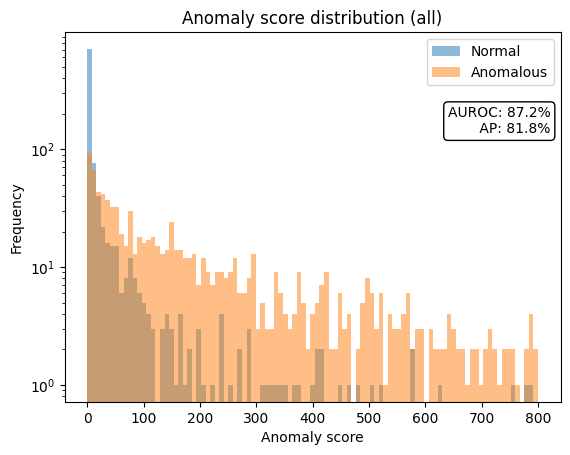

In [62]:
scripts.train_detector(
    cp_task, detector, save_path=None, eval_batch_size=64, batch_size=64
)

# Use original filtered dataset

In [63]:
import blobfile as bf
import json

name = "hex"

def load_tiny_natural_mechanisms_data(name="hex"):
    path = f"gs://arc-ml-public/distinctions/datasets/{name}_task.json"
    with bf.BlobFile(path) as f:
        task_data = json.load(f)
    # train_data = TinyNaturalMechanismsDataset(task_data["train"])
    # normal_test_data = TinyNaturalMechanismsDataset(task_data["test_non_anomalous"])
    # anomalous_test_data = TinyNaturalMechanismsDataset(task_data["test_anomalous"])
    return task_data
task_data = load_tiny_natural_mechanisms_data(name)

In [64]:
from cupbearer.tasks.tiny_natural_mechanisms import tiny_natural_mechanisms
# reloading data, but shrug, can add this to the tiny natural mechanisms builder later
task_model = tiny_natural_mechanisms("hex", "mps").model

Loaded pretrained model attn-only-1l into HookedTransformer
Moving model to device:  mps


In [65]:
tokens = task_data["train"][0]["prefix_tokens"]

In [66]:
decoded = task_model.tokenizer.decode(tokens)
reconcoded = model.tokenizer.encode(decoded)
tokens, decoded, reconcoded

([70, 27, 68, 18, 15, 14426, 26, 19, 15, 22, 19, 18, 26, 15, 1234, 25],
 'd9b0-bd81-4108-be7',
 [0, 69, 26, 67, 17, 14, 14836, 3593, 14, 21, 12347, 14, 1257, 24])

In [67]:
# decode and recode tokens
def decode_and_encode(tokens, task_model, model):
    decoded = task_model.tokenizer.decode(tokens)
    reencoded = model.tokenizer.encode(decoded)
    return reencoded


def decode_encode_data(data, task_model, model):
    return [
        {
            "prefix_tokens": decode_and_encode(example["prefix_tokens"], task_model, model),
            "completion_token": decode_and_encode([example["completion_token"]], task_model, model),
            "og_effect_prob": example["effect_prob"],
        }
        for example in data
    ]

In [68]:
task_data["train"] = decode_encode_data(task_data["train"], task_model, model)
task_data["test_non_anomalous"] = decode_encode_data(task_data["test_non_anomalous"], task_model, model)
task_data["test_anomalous"] = decode_encode_data(task_data["test_anomalous"], task_model, model)

In [69]:
# create hex mask behavior, compare effect tokens
from hex_nn.masking.behaviors import HexMasker 

new_hex_bevaior = HexMasker(model.tokenizer)

In [70]:
new_effect_tokens = list(set(decode_and_encode(task_data["effect_tokens"], task_model, model)))
len(new_effect_tokens), len(new_hex_bevaior.effect_tokens)

(70, 1319)

In [71]:
with torch.no_grad():
    out = model(torch.tensor(task_data["train"][0]["prefix_tokens"]))
out

tensor([[[  12.7702, -828.1210,   10.3165,  ..., -828.1143, -828.1185,
          -828.1166],
         [  13.3468, -824.1162,   10.0428,  ..., -824.1099, -824.1128,
          -824.1119],
         [  14.6334, -821.1580,   11.5582,  ..., -821.1522, -821.1564,
          -821.1549],
         ...,
         [  11.8589, -817.0472,   10.5024,  ..., -817.0408, -817.0458,
          -817.0437],
         [  13.8377, -825.1594,   10.3448,  ..., -825.1527, -825.1571,
          -825.1562],
         [  18.1620, -824.4803,   13.0701,  ..., -824.4733, -824.4778,
          -824.4769]]], device='mps:0')

In [72]:
out.shape

torch.Size([1, 14, 50304])

In [73]:
torch.softmax(out[:, -1], dim=-1)[:, new_effect_tokens].sum()

tensor(0.3938, device='mps:0')

In [74]:
def get_effect_prob(example, model, new_effect_tokens):
    with torch.no_grad():
        output = model(torch.tensor([example["prefix_tokens"]]))
        probs = torch.softmax(output[:, -1], dim=-1)
        effect_prob = probs[:, new_effect_tokens].sum().item()
        if effect_prob <= 0 or effect_prob > 1:
            raise ValueError("Effect probability is out of bounds")
    return effect_prob

def get_effect_prob_data(data, model, new_effect_tokens, split=None):
    return [
        {
            **example,
            "effect_prob": get_effect_prob(example, model, new_effect_tokens),
        }
        for example in tqdm(data, desc=f"effect prob {split if split is not None else ''}")
    ]

In [117]:
def pad_tokens(tokens, pad_token_id, max_len=16):
    tokens_len = len(tokens)
    return [pad_token_id] * (max(max_len - tokens_len, 0)) + tokens[-min(tokens_len, max_len):]

def pad_tokens_data(data, pad_token_id, max_len=16):
    return [
        {
            "prefix_tokens": pad_tokens(example.pop("prefix_tokens"), pad_token_id, max_len=max_len),
            **example
        }
        for example in data
    ]

In [118]:
from hex_nn.datasets import cache_json
from hex_nn.masking.behaviors import registry as behavior_registry
#TODO: rerun effect probs with padded tokens
@cache_json("distinctions/{behavior_name}_{model_name}_task.json")
def convert_task_to_model(behavior_name, model_name, task_data, task_model, model):
    # decode and recode tokens
    task_data["train"] = decode_encode_data(task_data["train"], task_model, model)
    task_data["test_non_anomalous"] = decode_encode_data(task_data["test_non_anomalous"], task_model, model)
    task_data["test_anomalous"] = decode_encode_data(task_data["test_anomalous"], task_model, model)
    # pad tokens 
    task_data["train"] = pad_tokens_data(task_data["train"], model.tokenizer.pad_token_id)
    task_data["test_non_anomalous"] = pad_tokens_data(task_data["test_non_anomalous"], model.tokenizer.pad_token_id)
    task_data["test_anomalous"] = pad_tokens_data(task_data["test_anomalous"], model.tokenizer.pad_token_id)
    # add model effect probabilities
    new_behavior = behavior_registry[behavior_name](model.tokenizer)
    new_effect_tokens = list(new_behavior.effect_tokens)
    task_data["effect_tokens"] = new_effect_tokens
    task_data["train"] = get_effect_prob_data(task_data["train"], model, new_effect_tokens, "train")
    task_data["test_non_anomalous"] = get_effect_prob_data(task_data["test_non_anomalous"], model, new_effect_tokens, "test_non_anomalous")
    task_data["test_anomalous"] = get_effect_prob_data(task_data["test_anomalous"], model, new_effect_tokens, "test_anomalous")
    return task_data

In [124]:
task_data = load_tiny_natural_mechanisms_data(name)
new_task_data = convert_task_to_model("hex", "pythia-70m", task_data, task_model, model)

In [120]:
padded_tokens = pad_tokens(task_data["train"][0]["prefix_tokens"], model.tokenizer.pad_token_id)
padded_tokens, len(padded_tokens)

([70, 27, 68, 18, 15, 14426, 26, 19, 15, 22, 19, 18, 26, 15, 1234, 25], 16)

In [121]:
{"x": 1}.pop("x")

1

In [125]:
# pad tokens
new_task_data["train"] = pad_tokens_data(new_task_data["train"], model.tokenizer.pad_token_id)
new_task_data["test_non_anomalous"] = pad_tokens_data(new_task_data["test_non_anomalous"], model.tokenizer.pad_token_id)
new_task_data["test_anomalous"] = pad_tokens_data(new_task_data["test_anomalous"], model.tokenizer.pad_token_id)

In [102]:
assert all(len(example["prefix_tokens"]) == 16 for example in task_data["train"])

In [103]:
len([example for example in new_task_data["train"] if len([t for t in example["prefix_tokens"] if t != model.tokenizer.pad_token_id]) == 16])

4421

In [104]:
np.mean((np.array([example["og_effect_prob"] for example in new_task_data["train"]]) > 0.1).astype(float))

0.96142578125

In [105]:
np.mean([abs(example["og_effect_prob"] - example["effect_prob"]) for example in new_task_data["train"]])

0.26315002891898853

In [106]:
np.mean([(example["og_effect_prob"] - example["effect_prob"]) for example in new_task_data["train"]])

0.09783912390252514

In [107]:
#TODO: look at sample decodings for maximally disagreeing examples, maybe filter out?

In [126]:
# build new task
from cupbearer.tasks import Task
from cupbearer.tasks.tiny_natural_mechanisms import TinyNaturalMechanismsDataset

train_data = TinyNaturalMechanismsDataset(new_task_data["train"])
normal_test_data = TinyNaturalMechanismsDataset(new_task_data["test_non_anomalous"])
anomalous_test_data = TinyNaturalMechanismsDataset(new_task_data["test_anomalous"])

cp_new_task = Task.from_separate_data(
    model=model, 
    trusted_data=train_data,
    clean_test_data=normal_test_data,
    anomalous_test_data=anomalous_test_data,
)

In [127]:
def get_activation_at_last_token(
    activation: torch.Tensor, inputs: list[list[int]], name: str
):
    if activation.ndim == 3:
        # Residual stream or equivalent, shape is (batch, seq, hidden)
        return activation[:, -1, :]
    elif activation.ndim == 4 and activation.shape[-1] == activation.shape[-2]:
        # Attention, shape is (batch, num_heads, query, key)
        # TODO: this could also be Q/K/V if n_heads happens to be head_dim
        return activation[:, :, -1, :].reshape(activation.shape[0], -1)
    elif activation.ndim == 4:
        # Query/key/value, shape is (batch, seq, num_heads, hidden)
        return activation[:, -1, :, :].reshape(activation.shape[0], -1)
    else:
        raise ValueError(f"Unexpected activation shape: {activation.shape}")

In [147]:
for name, _ in cp_task.model.named_modules():
    print(name)


embed
hook_embed
blocks
blocks.0
blocks.0.ln1
blocks.0.ln1.hook_scale
blocks.0.ln1.hook_normalized
blocks.0.ln2
blocks.0.ln2.hook_scale
blocks.0.ln2.hook_normalized
blocks.0.attn
blocks.0.attn.hook_k
blocks.0.attn.hook_q
blocks.0.attn.hook_v
blocks.0.attn.hook_z
blocks.0.attn.hook_attn_scores
blocks.0.attn.hook_pattern
blocks.0.attn.hook_result
blocks.0.attn.hook_rot_k
blocks.0.attn.hook_rot_q
blocks.0.mlp
blocks.0.mlp.hook_pre
blocks.0.mlp.hook_post
blocks.0.hook_attn_in
blocks.0.hook_q_input
blocks.0.hook_k_input
blocks.0.hook_v_input
blocks.0.hook_mlp_in
blocks.0.hook_attn_out
blocks.0.hook_mlp_out
blocks.0.hook_resid_pre
blocks.0.hook_resid_post
blocks.1
blocks.1.ln1
blocks.1.ln1.hook_scale
blocks.1.ln1.hook_normalized
blocks.1.ln2
blocks.1.ln2.hook_scale
blocks.1.ln2.hook_normalized
blocks.1.attn
blocks.1.attn.hook_k
blocks.1.attn.hook_q
blocks.1.attn.hook_v
blocks.1.attn.hook_z
blocks.1.attn.hook_attn_scores
blocks.1.attn.hook_pattern
blocks.1.attn.hook_result
blocks.1.attn.hook

In [136]:
names = [
    # "hook_embed.output",
    # "blocks.1.hook_resid_post.output",
    # "blocks.2.hook_resid_post.output",
    # "blocks.3.hook_resid_post.output",
    # "blocks.4.hook_resid_post.output",
    # "blocks.0.hook_attn_out.output"
    "blocks.1.hook_attn_out.output",
    "blocks.2.hook_attn_out.output",
    "blocks.3.hook_attn_out.output",
    "blocks.4.hook_attn_out.output",
    # "blocks.5.hook_attn_out.output"
]

detector = detectors.MahalanobisDetector(
    names, layer_aggregation="mean", activation_processing_func=get_activation_at_last_token
)

100%|██████████| 256/256 [00:08<00:00, 29.20it/s]
2024-06-25 14:56:16.832 | INFO     | cupbearer.detectors.anomaly_detector:eval:152 - AUC_ROC (all): 0.8782
2024-06-25 14:56:16.832 | INFO     | cupbearer.detectors.anomaly_detector:eval:153 - AP (all): 0.8273


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.8781576156616211,
               'AP': 0.8272973965740064}}),
 {'all': <Figure size 640x480 with 1 Axes>})

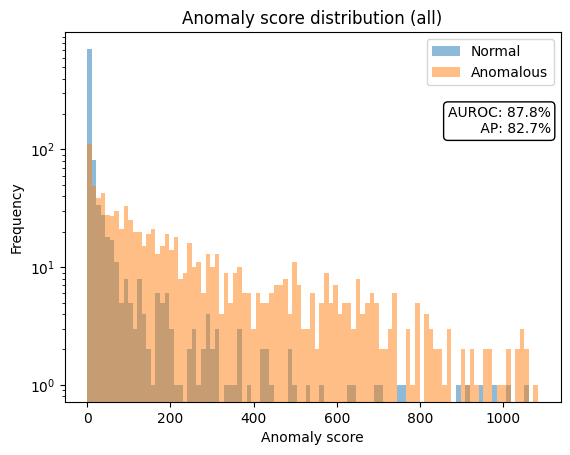

In [137]:
scripts.train_detector(
    cp_new_task, detector, save_path=None, eval_batch_size=64, batch_size=64
)

# Run Edge Attribution Patching on Hex

In [32]:
from eap.eap_wrapper import EAP

In [33]:
device = "mps"

In [34]:
# TODO: look back at edge attribution example
model.set_use_split_qkv_input(True)
model.set_use_attn_result(True)

In [41]:
# use mean probability over effect tokens as metric 
def effect_prob_func(logits, effect_tokens):
    assert logits.ndim == 3
    probs = logits.softmax(-1)
    # Sum over vocab and batch dim (for now we're just computing attribution values, we'll deal with per data instance later)
    out = probs[:, -1, effect_tokens].mean()
    print("metric", out)
    return out

In [42]:
effect_tokens = torch.tensor(task["effect_tokens"])

In [43]:
trusted_tokens = torch.stack(
    [torch.tensor(x["prefix_tokens"]) for x in cp_task.trusted_data.data], 
    dim=0).to(device)

In [44]:
model.reset_hooks()

graph = EAP(
    model=model,
    clean_tokens=trusted_tokens,
    metric=partial(effect_prob_func, effect_tokens=effect_tokens), 
    # upstream_nodes=["head"],
    # downstream_nodes=["head"],
    batch_size=64
)

Saving activations requires 0.0001 GB of memory per token


  0%|          | 0/256 [00:02<?, ?it/s]


AssertionError: Cannot add hook blocks.0.hook_mlp_in if use_hook_mlp_in is False

In [39]:
top_edges = graph.top_edges(n=20, abs_scores=True)

In [40]:
#TODO: fix the edge attribution code (maybe missing a negative? should trace through)
for from_edge, to_edge, score in top_edges:
    print(f'{from_edge} -> [{round(score, 3)}] -> {to_edge}')

head.2.7 -> [0.0] -> head.3.0.k
head.0.6 -> [-0.0] -> head.1.1.v
head.2.7 -> [0.0] -> head.3.3.k
head.0.6 -> [0.0] -> head.1.0.v
head.0.0 -> [0.0] -> head.2.1.v
head.0.6 -> [-0.0] -> head.2.7.v
head.0.0 -> [-0.0] -> head.3.4.v
head.0.6 -> [-0.0] -> head.1.3.v
head.0.5 -> [0.0] -> head.1.3.v
head.0.0 -> [0.0] -> head.2.7.v
head.0.6 -> [-0.0] -> head.2.1.v
head.0.0 -> [-0.0] -> head.3.3.v
head.1.3 -> [0.0] -> head.2.7.v
head.0.6 -> [-0.0] -> head.1.4.v
head.0.6 -> [-0.0] -> head.2.5.v
head.2.7 -> [0.0] -> head.3.0.q
head.0.3 -> [0.0] -> head.2.7.v
head.0.3 -> [-0.0] -> head.1.7.v
head.1.3 -> [-0.0] -> head.2.5.v
head.1.3 -> [0.0] -> head.3.0.q
